# JetBlue Customer Sentiment

## Hypothesis:
We believe customer sentiment of JetBlue to be mostly positive, with the occasional yet unavoidable bad experience.

In [267]:
# Necessary imports
import ast
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from math import sqrt
import matplotlib.pyplot as plt
plt.rcdefaults()

In [250]:
# Parsing and filtering Twitter data from the past year: 10/27/18 - 10/27/19
with open('bigdata.txt', encoding='utf8') as f:
    lines = f.readlines()
    
tweets = []
dicts = []

threshold = 1

for string in lines:
    dic = ast.literal_eval(string)
    if ('jetblue' in dic['tweet'].lower() or 'jet blue' in dic['tweet'].lower()) and 'player of the' not in dic['tweet'].lower() and 'play of the' not in dic['tweet'].lower() and dic['likes_count'] >= threshold:
        tweets.append(dic['tweet'])
        dicts.append(dic)

In [251]:
print('Number of tweets:')
print(len(tweets))
print('Greatest number of retweets for a tweet:')
print(max([x['retweets_count'] for x in dicts]))
print('Greatest number of likes for a tweet:')
print(max([x['likes_count'] for x in dicts]))

Number of tweets:
66008
Greatest number of retweets for a tweet:
15866
Greatest number of likes for a tweet:
64534


In [252]:
# Analyzing sentiment of all tweets
analyzer = SentimentIntensityAnalyzer()
perceptions = []
for idx, tweet in enumerate(tweets):
    
    # Calculating sentement, like-count, and retweet-count for the given tweet
    s = analyzer.polarity_scores(tweet)['compound']    
    l = dicts[idx]['likes_count']
    r = dicts[idx]['retweets_count']
    
    # Calculating the overall public perception score
    val = s * sqrt(l + r)
    
    perceptions.append((val, idx))


In [253]:
# Sorting based on perception
sorted_perceptions = sorted(perceptions)
print('Perception of five most negative tweets:')
print(sorted_perceptions[:5])
print('Perception of five most positive tweets:')
print(sorted_perceptions[-5:])

Perception of five most negative tweets:
[(-123.02739504411204, 32157), (-56.1101323213553, 11847), (-54.2244519308402, 31763), (-46.45583090721767, 14819), (-45.39022125876894, 14818)]
Perception of five most positive tweets:
[(71.5603705632524, 19007), (78.63425004411246, 48098), (93.0747687131158, 18678), (129.62404498425437, 29853), (180.35989642046263, 35719)]


In [290]:
# Only consider the 20% most positive and 20% most negative data for n-gram model
percentage = int(.2 * len(sorted_perceptions))

worst_tweets = [tweets[x[1]] for x in sorted_perceptions[:percentage]]
best_tweets = [tweets[x[1]] for x in sorted_perceptions[-percentage:]]

In [291]:
# Tokenize the tweets

punctuation = {'.', ',', '!', '?', '"', ' '}

def tokenize(tweets):
    
    token_list = []
    
    for tweet in tweets:
        
        word = []
        
        for char in tweet:
            if char not in punctuation:
                word.append(char)
            else:
                if word != []:
                    token_list.append(''.join(word).lower())
                word = []
        
        if word != []:
            token_list.append(''.join(word))
        
        token_list.append('<temp>')
    
    return token_list
    

In [292]:
# Create the n-gram models: uni, bi, tri
delete_words = {'<temp>', 'pic', 'twitter', 'https://twitter', 'game'}
skip_words = {'hey', 'get', 'jet', 'had', 'out', 'great', 'have', 'all', 'just', 'but', 'as', 'blue', '&', 'yours', 'your', 'was', 'me', 'that', 'be', 'so', 'thanks', 'thank', 'and', 'it', 'and', 'to', 'the', 'a', 'jetblue', '@jetblue', '#jetblue', 'for', 'an', 'i', 'in', 'of', 'on', 'my', 'is', 'you', 'at', 'he', 'she', 'they', 'we', 'with', 'this', 'our', 'from'}

def unigrams(tokens):
    result = {}
    
    for token in tokens:
        if token not in delete_words and token not in skip_words:
            if token not in result:
                result[token] = 1
            else:
                result[token] += 1
    return result

def bigrams(tokens):
    
    result = {}
    
    for token1, token2 in zip(tokens[:-1], tokens[1:]):
        if not (token1 in skip_words and token2 in skip_words) and not (token1 in delete_words or token2 in delete_words):
            if (token1, token2) not in result:
                result[(token1, token2)] = 1
            else:
                result[(token1, token2)] += 1
    return result

def trigrams(tokens):
    
    result = {}
    
    for token1, token2, token3 in zip(tokens[:-2], tokens[1:-1], tokens[2:]):
        if not (token1 in skip_words and token2 in skip_words and token3 in skip_words) and not (token1 in delete_words or token2 in delete_words or token3 in delete_words):
            if (token1, token2, token3) not in result:
                result[(token1, token2, token3)] = 1
            else:
                result[(token1, token2, token3)] += 1
    return result

In [293]:
best_tokens = tokenize(best_tweets)
worst_tokens = tokenize(worst_tweets)

best_unigram = unigrams(best_tokens)
worst_unigram = unigrams(worst_tokens)
best_bigram = bigrams(best_tokens)
worst_bigram = bigrams(worst_tokens)
best_trigram = trigrams(best_tokens)
worst_trigram = trigrams(worst_tokens)

In [294]:
def get_n_greatest(gram, n):
    lst = sorted(list(gram.items()), key=lambda x: x[1], reverse=True)
    return lst[:n]


print('Positive Unigram:')
print(get_n_greatest(best_unigram, 20))
print('\nNegative Unigram:')
print(get_n_greatest(worst_unigram, 20))
print('\nPositive Bigram:')
print(get_n_greatest(best_bigram, 20))
print('\nNegative Bigram:')
print(get_n_greatest(worst_bigram, 20))
print('\nPositive Trigram:')
print(get_n_greatest(best_trigram, 20))
print('\nNegative Trigram:')
print(get_n_greatest(worst_trigram, 20))

print('\nNotable positive examples: ')
print('"customer service", "free wifi", "flight attendant", "to boston"')
print('\nNotable negative examples: ')
print('"customer service", "hour delay", "new york", "to jfk", "flight attendants", "jetblue pilots"')
print('"on the tarmac", "pilots accused of drugging ...", "biased biometric boarding program ..."')

Positive Unigram:
[('flight', 3402), ('are', 1388), ('free', 1235), ('love', 1066), ('like', 1018), ('us', 936), ('best', 916), ('service', 876), ('new', 857), ('their', 842), ('time', 833), ('not', 823), ('airline', 805), ('more', 784), ('flying', 762), ('-', 759), ('flights', 752), ('today', 752), ('good', 743), ('now', 738)]

Negative Unigram:
[('flight', 4944), ('no', 2732), ('not', 1848), ('are', 1624), ('delayed', 1537), ('now', 1413), ('hours', 1140), ('time', 1113), ('plane', 1069), ('has', 1008), ('been', 1003), ('fly', 902), ('i’m', 876), ('or', 870), ('after', 858), ('flights', 855), ('when', 848), ('up', 816), ('delay', 813), ('one', 797)]

Positive Bigram:
[(('the', 'best'), 606), (('@jetblue', 'flight'), 482), (('customer', 'service'), 387), (('i', 'love'), 375), (('free', 'wifi'), 352), (('my', 'flight'), 341), (('to', 'fly'), 275), (('flight', 'to'), 264), (('i', 'am'), 254), (('to', 'see'), 252), (('the', 'flight'), 239), (('one', 'of'), 235), (('–', 'at'), 233), (('fl

In [286]:
# Check time-based perception data for days
week_day = dicts[-1]['date'].split('-')[2]
day_num = 0
totals = []
total = 0

for idx, dict_data in enumerate(dicts[::-1]):
    date = dict_data['date']
    _, _, day = date.split('-')
    if day != week_day:
        week_day = day
        totals.append(total)
        total = 0
    else:
        total += perceptions[idx][0]

if day_num != 0:
    totals.append(total)

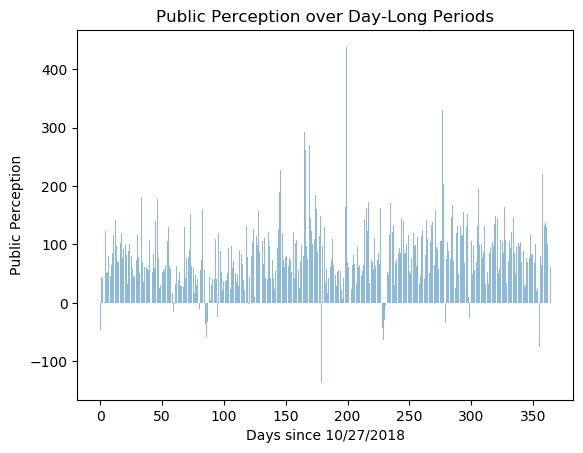

In [287]:
plt.bar(range(len(totals)), totals, align='center', alpha=0.5)
plt.ylabel('Public Perception')
plt.xlabel('Days since 10/27/2018')
plt.title('Public Perception over Day-Long Periods')

plt.show()

In [288]:
# Check time-based perception data for weeks
week_day = dicts[-1]['date'].split('-')[2]
day_num = 0
totals = []
total = 0

for idx, dict_data in enumerate(dicts[::-1]):
    date = dict_data['date']
    _, _, day = date.split('-')
    if day != week_day:
        day_num += 1
        week_day = day
    if day_num == 7:
        day_num = 0
        totals.append(total)
        total = 0
    else:
        total += perceptions[idx][0]

if day_num != 0:
    totals.append(total)


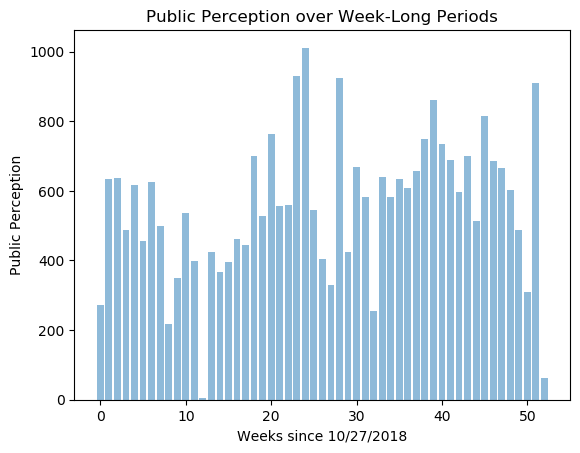

In [289]:
plt.bar(range(len(dates)), totals, align='center', alpha=0.5)
# plt.xticks(range(len(dates)), dates)
plt.ylabel('Public Perception')
plt.xlabel('Weeks since 10/27/2018')
plt.title('Public Perception over Week-Long Periods')

plt.show()